In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format


import warnings
warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_prices_df = pd.read_sql_query('select * from houseprices', con=engine)

engine.dispose()

In [3]:
#Quick check on the number of rows and the columns in the dataframe
print(len(house_prices_df))
house_prices_df.iloc[:,:81].head(5)

1460


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


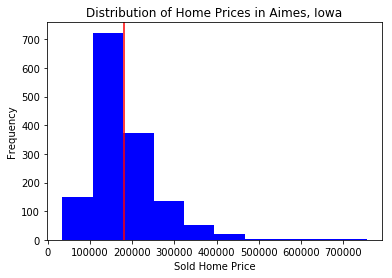

Mean house price in Aimes:  180921.19589041095


In [4]:
#Since we are estimating the saleprice I want to check the distribution
plt.hist(house_prices_df['saleprice'], color ='b')
plt.xlabel('Sold Home Price')
plt.ylabel('Frequency')
plt.axvline(house_prices_df['saleprice'].mean(), color='r', alpha=1.0)
plt.title('Distribution of Home Prices in Aimes, Iowa')
plt.show()
print('Mean house price in Aimes: ', house_prices_df['saleprice'].mean())

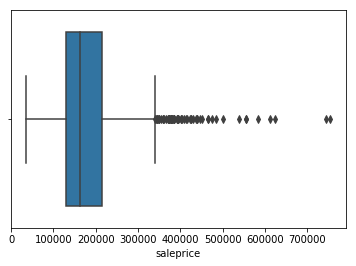

In [31]:
sns.boxplot(house_prices_df['saleprice'])
plt.show()

### Feature Engineering

In [5]:
house_prices_df['total_sf'] = house_prices_df['totalbsmtsf'] + house_prices_df['firstflrsf'] + house_prices_df['secondflrsf']

In [6]:
num_car_garage = pd.get_dummies(house_prices_df['garagecars'], prefix='car_garage')
house_prices_df = pd.concat([house_prices_df, num_car_garage], axis=1)


In [7]:
garage_type = pd.get_dummies(house_prices_df['garagetype'], prefix='garagetype')
house_prices_df = pd.concat([house_prices_df, garage_type], axis=1)


In [8]:
paved = pd.get_dummies(house_prices_df['paveddrive'], prefix='paved_driveway')
house_prices_df = pd.concat([house_prices_df, paved], axis=1)

In [9]:
garage_finish = pd.get_dummies(house_prices_df['garagefinish'], prefix='garagefinish')
house_prices_df = pd.concat([house_prices_df, garage_finish], axis=1)

In [10]:
#Does the house have an above average kitchen feature
house_prices_df['awesome_kitchen'] = 9999

In [11]:
house_prices_df.loc[(house_prices_df['kitchenqual'] == 'Ex') | (house_prices_df['kitchenqual'] == 'Gd'), 
                    ['awesome_kitchen']] = 1
house_prices_df.loc[(house_prices_df['kitchenqual'] == 'Fa') | (house_prices_df['kitchenqual'] == 'TA'), 
                    ['awesome_kitchen']] = 0
house_prices_df.awesome_kitchen.value_counts()

0    774
1    686
Name: awesome_kitchen, dtype: int64

In [12]:
#Is the garage attached to the house feature
house_prices_df['attached_garage'] = 9999
house_prices_df.loc[(house_prices_df['garagetype'] == 'Attchd') | (house_prices_df['garagetype'] == 'BuiltIn'), 
                    ['attached_garage']] = 1
house_prices_df.loc[(house_prices_df['garagetype'] != 'Attchd') & (house_prices_df['garagetype'] != 'BuiltIn'), 
                    ['attached_garage']] = 0
house_prices_df.attached_garage.value_counts()

1    958
0    502
Name: attached_garage, dtype: int64

In [13]:
house_prices_df['yard_sf'] = house_prices_df['lotarea'] - house_prices_df['firstflrsf']

In [14]:
hillside = pd.get_dummies(house_prices_df['landcontour'], prefix='landcontour')
house_prices_df = pd.concat([house_prices_df, hillside], axis=1)

### 1st Iteration of the Model

In [25]:
features = house_prices_df[[
                    'awesome_kitchen', 
                    'total_sf', 
                    'paved_driveway_Y',
                    'attached_garage', 
                    'garagetype_2Types', 
                    'car_garage_3', 
                    'garagefinish_Fin', 
                    'yard_sf', 
                    'landcontour_HLS'
                    ]
                   ]
Y = house_prices_df['saleprice']
X = features

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 465)

X_train = sm.add_constant(X_train)

results = sm.OLS(Y_train, X_train).fit()

print('The number of observations in training: {}'.format(len(X_train)))
print('The number of observations in validation: {}'.format(len(X_val)))
print('The number of observations in test: {}'.format(len(X_test)))
results.summary()

The number of observations in training: 934
The number of observations in validation: 234
The number of observations in test: 292


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     292.3
Date:                Tue, 25 Jun 2019   Prob (F-statistic):          3.02e-263
Time:                        06:48:50   Log-Likelihood:                -11192.
No. Observations:                 934   AIC:                         2.240e+04
Df Residuals:                     924   BIC:                         2.245e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              2.299e+04   6063.517      3.792      0.000    1.11e+04    3.49e+04
awesome_kitchen     3.08e+04   3040.868     10.128      0.000    2.48e+04    3.68e+04
total_sf             39.5935      1.943     20.377      0.000      35.780      43.407
paved_driveway_Y   1.309e+04   5123.790      2.555      0.011    3034.454    2.31e+04
attached_garage     1.68e+04   3200.580      5.250      0.000    1.05e+04    2.31e+04
garagetype_2Types -7.565e+04   1.79e+04     -4.219      0.000   -1.11e+05   -4.05e+04
car_garage_3       6.511e+04   4446.105     14.645      0.000    5.64e+04    7.38e+04
garagefinish_Fin   1.666e+04   3249.587      5.127      0.000    1.03e+04     2.3e+04
yard_sf               0.4606      0.115      3.997      0.000       0.234       0.687
landcontour_HLS     2.76e+04   6790.425      4.065      0.000    1.43e+04    4.09e+04
==============================================================================
Omnibus:                      417.096   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22245.362
Skew:                          -1.244   Prob(JB):                         0.00
Kurtosis:                      26.779   Cond. No.                     2.16e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.16e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

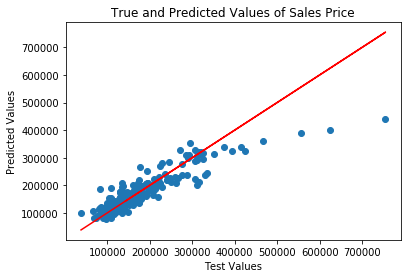

Mean absolute error of the prediction is:  26080.72076412564
Mean squared error of the prediction is:  1766540020.1281803
Root mean squared error of the prediction is:  42030.22745748802
Mean absolute percentage error of the prediction is:  15.173053720260937


In [26]:
X_val = sm.add_constant(X_val)
Y_val_pred = results.predict(X_val)

plt.scatter(Y_val, Y_val_pred)
plt.plot(Y_val, Y_val, color='red')
plt.xlabel('Test Values')
plt.ylabel('Predicted Values')
plt.title('True and Predicted Values of Sales Price')
plt.show()

mae = mean_absolute_error(Y_val, Y_val_pred)
mean_sq_err = mse(Y_val, Y_val_pred)
root_mse = rmse(Y_val, Y_val_pred)
ma_perc_err = np.mean(np.abs((Y_val - Y_val_pred) / Y_val)) *100

print('Mean absolute error of the prediction is: ', mae)
print('Mean squared error of the prediction is: ', mean_sq_err)
print('Root mean squared error of the prediction is: ', root_mse)
print('Mean absolute percentage error of the prediction is: ', ma_perc_err)

The model seems to do a really good job of predicting home values at the lower end of the market, but pretty poorly on the high end. There are fewer homes in the 400,000 dollar plus market which are outliers based on the boxplot above and what we know about the skewedness of the sale price variable. To try and assist with the upper end of the predictions we can add some features that will focus on the sales price in that range.

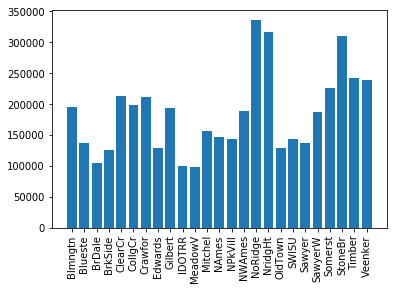

0    1317
1     143
Name: pricey_neighborhoods, dtype: int64
pricey_neighborhoods
0   165742.236
1   320716.231
Name: saleprice, dtype: float64
pricey_neighborhoods
0   0.414
1   0.986
Name: awesome_kitchen, dtype: float64


In [46]:
plt.bar(house_prices_df.groupby('neighborhood')['saleprice'].mean().index, 
        house_prices_df.groupby('neighborhood')['saleprice'].mean())
plt.xticks(rotation=90)
plt.show()

house_prices_df['pricey_neighborhoods'] = 9999
house_prices_df.loc[(house_prices_df.neighborhood == 'NoRidge') | 
                    (house_prices_df.neighborhood == 'NridgHt') | 
                    (house_prices_df.neighborhood == 'StoneBr'), 
                    ['pricey_neighborhoods']] = 1
house_prices_df.loc[(house_prices_df.neighborhood != 'NoRidge') & 
                    (house_prices_df.neighborhood != 'NridgHt') & 
                    (house_prices_df.neighborhood != 'StoneBr'), 
                    ['pricey_neighborhoods']] = 0   

print(house_prices_df.pricey_neighborhoods.value_counts())
print(house_prices_df.groupby('pricey_neighborhoods')['saleprice'].mean())
print(house_prices_df.groupby('pricey_neighborhoods')['awesome_kitchen'].mean())

Let's re-run the model with just the designation of 'pricey_neighborhood'. If that does not boost the upper end predictions then we can be more targetted with the feature and include a square footage interaction to really train the homes at the upper end of the market.

In [47]:
features = house_prices_df[[
                    'awesome_kitchen', 
                    'total_sf', 
                    'paved_driveway_Y',
                    'attached_garage', 
                    'garagetype_2Types', 
                    'car_garage_3', 
                    'garagefinish_Fin', 
                    'yard_sf', 
                    'landcontour_HLS', 
                    'pricey_neighborhoods'
                    ]
                   ]
Y = house_prices_df['saleprice']
X = features

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 465)

X_train = sm.add_constant(X_train)

results = sm.OLS(Y_train, X_train).fit()

print('The number of observations in training: {}'.format(len(X_train)))
print('The number of observations in validation: {}'.format(len(X_val)))
print('The number of observations in test: {}'.format(len(X_test)))
results.summary()

The number of observations in training: 934
The number of observations in validation: 234
The number of observations in test: 292


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     322.1
Date:                Tue, 25 Jun 2019   Prob (F-statistic):          6.85e-293
Time:                        15:39:21   Log-Likelihood:                -11119.
No. Observations:                 934   AIC:                         2.226e+04
Df Residuals:                     923   BIC:                         2.231e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 3.301e+04   5673.249      5.818      0.000    2.19e+04    4.41e+04
awesome_kitchen       2.671e+04   2835.416      9.421      0.000    2.11e+04    3.23e+04
total_sf                34.9425      1.838     19.010      0.000      31.335      38.550
paved_driveway_Y      1.346e+04   4745.445      2.836      0.005    4143.474    2.28e+04
attached_garage       1.492e+04   2968.050      5.028      0.000    9097.737    2.07e+04
garagetype_2Types    -5.804e+04   1.67e+04     -3.483      0.001   -9.07e+04   -2.53e+04
car_garage_3          4.596e+04   4397.004     10.453      0.000    3.73e+04    5.46e+04
garagefinish_Fin      1.705e+04   3009.737      5.664      0.000    1.11e+04     2.3e+04
yard_sf                  0.5625      0.107      5.255      0.000       0.352       0.773
landcontour_HLS       2.861e+04   6289.420      4.549      0.000    1.63e+04     4.1e+04
pricey_neighborhoods  5.845e+04   4706.352     12.420      0.000    4.92e+04    6.77e+04
==============================================================================
Omnibus:                      362.520   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16747.563
Skew:                          -1.009   Prob(JB):                         0.00
Kurtosis:                      23.646   Cond. No.                     2.17e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.17e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

So far so good. All of our important metrics have moved in the right direction (R-squared, AIC/BIC, and coefficients). The pricey_neighborhoods feature has a strong impact on the sale price of the home. Lets run the model on the validation set and check our predictions against the subset of data.

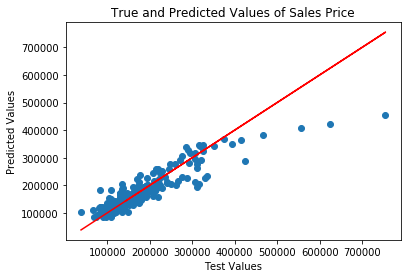

Mean absolute error of the prediction is:  25930.767872439286
Mean squared error of the prediction is:  1671942779.1255517
Root mean squared error of the prediction is:  40889.39690342169
Mean absolute percentage error of the prediction is:  15.094903010616036


In [48]:
X_val = sm.add_constant(X_val)
Y_val_pred = results.predict(X_val)

plt.scatter(Y_val, Y_val_pred)
plt.plot(Y_val, Y_val, color='red')
plt.xlabel('Test Values')
plt.ylabel('Predicted Values')
plt.title('True and Predicted Values of Sales Price')
plt.show()

mae = mean_absolute_error(Y_val, Y_val_pred)
mean_sq_err = mse(Y_val, Y_val_pred)
root_mse = rmse(Y_val, Y_val_pred)
ma_perc_err = np.mean(np.abs((Y_val - Y_val_pred) / Y_val)) *100

print('Mean absolute error of the prediction is: ', mae)
print('Mean squared error of the prediction is: ', mean_sq_err)
print('Root mean squared error of the prediction is: ', root_mse)
print('Mean absolute percentage error of the prediction is: ', ma_perc_err)

After adding the new feature we have decreased all of the relevant statistics and brought some of the data around the $400000 mark closer to the prediction line. Let's really single out the upper end of the market and put a square footage cutoff into those neighborhoods to see if we can predict that end of the model better.

In [54]:
house_prices_df.groupby('pricey_neighborhoods').total_sf.describe()

house_prices_df['pricey_hood_grt4000'] = 9999
house_prices_df.loc[(house_prices_df.pricey_neighborhoods == 1) & 
       (house_prices_df.total_sf > 4000), 
       ['pricey_hood_grt4000']] = 1
house_prices_df.loc[(house_prices_df.pricey_neighborhoods == 1) & 
       (house_prices_df.total_sf < 4000), 
       ['pricey_hood_grt4000']] = 0
house_prices_df.loc[house_prices_df.pricey_neighborhoods == 0, 
       ['pricey_hood_grt4000']] = 0
house_prices_df.pricey_hood_grt4000.value_counts()

0    1425
1      35
Name: pricey_hood_grt4000, dtype: int64

In [55]:
features = house_prices_df[[
                    'awesome_kitchen', 
                    'total_sf', 
                    'paved_driveway_Y',
                    'attached_garage', 
                    'garagetype_2Types', 
                    'car_garage_3', 
                    'garagefinish_Fin', 
                    'yard_sf', 
                    'landcontour_HLS', 
                    'pricey_neighborhoods', 
                    'pricey_hood_grt4000'
                    ]
                   ]
Y = house_prices_df['saleprice']
X = features

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 465)

X_train = sm.add_constant(X_train)

results = sm.OLS(Y_train, X_train).fit()

print('The number of observations in training: {}'.format(len(X_train)))
print('The number of observations in validation: {}'.format(len(X_val)))
print('The number of observations in test: {}'.format(len(X_test)))
results.summary()

The number of observations in training: 934
The number of observations in validation: 234
The number of observations in test: 292


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     314.7
Date:                Tue, 25 Jun 2019   Prob (F-statistic):          4.65e-303
Time:                        16:03:05   Log-Likelihood:                -11093.
No. Observations:                 934   AIC:                         2.221e+04
Df Residuals:                     922   BIC:                         2.227e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 3.805e+04   5558.320      6.845      0.000    2.71e+04     4.9e+04
awesome_kitchen       2.809e+04   2763.178     10.165      0.000    2.27e+04    3.35e+04
total_sf                32.4488      1.819     17.839      0.000      28.879      36.019
paved_driveway_Y      1.368e+04   4614.104      2.964      0.003    4620.749    2.27e+04
attached_garage       1.622e+04   2891.218      5.611      0.000    1.05e+04    2.19e+04
garagetype_2Types     -5.23e+04   1.62e+04     -3.224      0.001   -8.41e+04   -2.05e+04
car_garage_3          4.237e+04   4302.861      9.847      0.000    3.39e+04    5.08e+04
garagefinish_Fin      1.638e+04   2927.773      5.594      0.000    1.06e+04    2.21e+04
yard_sf                  0.5585      0.104      5.366      0.000       0.354       0.763
landcontour_HLS        2.85e+04   6115.238      4.660      0.000    1.65e+04    4.05e+04
pricey_neighborhoods  4.682e+04   4840.255      9.674      0.000    3.73e+04    5.63e+04
pricey_hood_grt4000   6.392e+04   8671.355      7.371      0.000    4.69e+04    8.09e+04
==============================================================================
Omnibus:                      351.886   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12847.863
Skew:                          -1.027   Prob(JB):                         0.00
Kurtosis:                      21.053   Cond. No.                     2.17e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.17e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

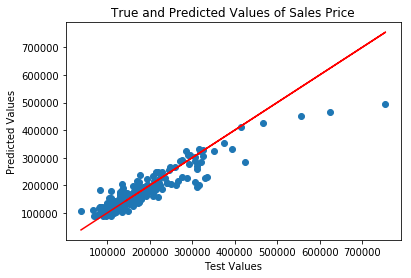

Mean absolute error of the prediction is:  24729.58158078221
Mean squared error of the prediction is:  1427482888.9505513
Root mean squared error of the prediction is:  37782.044531106985
Mean absolute percentage error of the prediction is:  14.872179914208902


In [56]:
X_val = sm.add_constant(X_val)
Y_val_pred = results.predict(X_val)

plt.scatter(Y_val, Y_val_pred)
plt.plot(Y_val, Y_val, color='red')
plt.xlabel('Test Values')
plt.ylabel('Predicted Values')
plt.title('True and Predicted Values of Sales Price')
plt.show()

mae = mean_absolute_error(Y_val, Y_val_pred)
mean_sq_err = mse(Y_val, Y_val_pred)
root_mse = rmse(Y_val, Y_val_pred)
ma_perc_err = np.mean(np.abs((Y_val - Y_val_pred) / Y_val)) *100

print('Mean absolute error of the prediction is: ', mae)
print('Mean squared error of the prediction is: ', mean_sq_err)
print('Root mean squared error of the prediction is: ', root_mse)
print('Mean absolute percentage error of the prediction is: ', ma_perc_err)

Now we have made a more substantial jump in our prediction parameters. RMSE has gone from 42,030 to 37,782, and the rest of the evaluation metrics have come down as well. By introducing two new variables that are closely related to one another, I could have introduced some multicollinearity into the model, but for this exercise I am more focused on the prediction capabilities of the model and less so on the features of importance to the sale prices.

For this last model, all of the model evaluation metrics are superior to the older models as well. So far I think this is the best model in all of the iterations that have been done from my perspective.